<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/redes_generativas_adversarias/introducci%C3%B3n_a_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

from IPython import display

In [2]:
(X_train, _), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255

In [3]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

In [4]:
def plot_multiple_images(images, n_cols=None, epoch=0):
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    fig = plt.figure(figsize=(n_cols, n_rows))
    fig.suptitle(f"Epochs {epoch}", fontsize="x-large")
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
  
    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

### Generador

In [5]:
random_normal_dimensions = 32

generator = Sequential()
generator.add(Dense(64, activation="selu", input_shape=[random_normal_dimensions]))
generator.add(Dense(128, activation="selu"))
generator.add(Dense(28 * 28, activation="sigmoid"))
generator.add(Reshape([28, 28]))

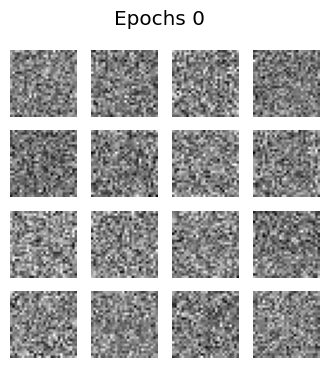

In [6]:
test_noise = tf.random.normal([16, random_normal_dimensions])
test_image = generator(test_noise)
plot_multiple_images(test_image, n_cols=4)

### Discriminador

In [7]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28, 28]))
discriminator.add(Dense(128, activation="selu"))
discriminator.add(Dense(64, activation="sigmoid"))
discriminator.add(Dense(1, activation="sigmoid"))

In [8]:
gan = Sequential([generator, discriminator])

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Época {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Fase 1 - Discriminaodr
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Fase 2 - Generador
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)

    plot_multiple_images(fake_images, 8, epoch)
    plt.show()

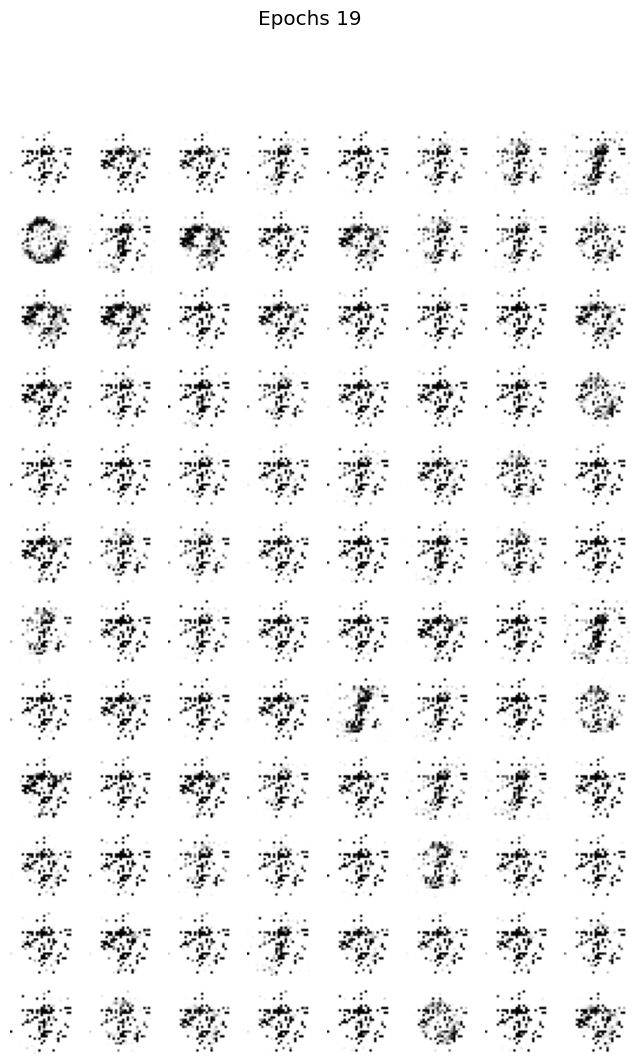

CPU times: user 3min 19s, sys: 12.3 s, total: 3min 32s
Wall time: 3min 22s


In [11]:
%%time
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)

**Por hacer**

* Descripción de la arquitectura
* Añadir comentarios
* Configurar al menos 100 iteraciones
* Referencias